In [20]:
''' Import libraries '''
from IPython import display
from sklearn import metrics
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from tensorflow.python.data import Dataset

import math
import numpy as np
import pandas as pd
import tensorflow as tf

In [21]:
''' Set settings for pandas to printed data '''
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [22]:
housing_dataframe = pd.read_csv('https://storage.googleapis.com/mledu-datasets/california_housing_train.csv', sep = ',')

In [23]:
''' Shufffle dataset '''
housing_dataframe = housing_dataframe.reindex(np.random.permutation(housing_dataframe.index))
housing_dataframe['median_house_value'] /= 1000
housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10869,-120.8,39.3,14.0,3338.0,608.0,1373.0,562.0,3.7,160.1
3650,-117.9,33.9,32.0,1683.0,273.0,719.0,263.0,5.4,243.6
5329,-118.2,34.2,37.0,1997.0,361.0,1037.0,363.0,3.8,210.3
2515,-117.6,33.5,7.0,7684.0,1088.0,2812.0,1057.0,6.3,387.3
14416,-122.1,37.4,36.0,2607.0,551.0,1165.0,523.0,5.2,373.1


In [24]:
''' Define features and targets series '''
features = housing_dataframe[['population']]
targets = housing_dataframe['median_house_value']

features_ttt = {key: np.array(value) for key,value in dict(features).items()}
features_ttt

{'population': array([1373.,  719., 1037., ...,  856.,  766., 4614.])}

In [25]:
''' Create a tensor from the features and targets data'''
ds = Dataset.from_tensor_slices((features_ttt, targets))
ds

<TensorSliceDataset shapes: ({population: ()}, ()), types: ({population: tf.float64}, tf.float64)>

In [26]:
''' Construct a feature collum basing on the features series '''
features_columns = [tf.feature_column.numeric_column('population')]

In [27]:
''' Init a linear model using gradient descent optimizer '''
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.0000001)
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = features_columns,
    optimizer = optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Nguyen\\AppData\\Local\\Temp\\tmps59isiem', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000216B0E53A58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [28]:
''' Define the input function '''
def input_fn(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
    """Trains a linear regression model of one feature.
  
    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Whether to shuffle the data.
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
        Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key, value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [29]:
''' Train the model '''
_ = linear_regressor.train(
    input_fn = lambda: input_fn(features, targets),
    steps = 1000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Nguyen\AppData\Local\Temp\tmps59isiem\model.ckpt.
INFO:tensorflow:loss = 3136.0, step = 0
INFO:tensorflow:global_step/sec: 492.248
INFO:tensorflow:loss = 74932.18, step = 100 (0.203 sec)
INFO:tensorflow:global_step/sec: 711.05
INFO:tensorflow:loss = 213.67868, step = 200 (0.141 sec)
INFO:tensorflow:global_step/sec: 799.918
INFO:tensorflow:loss = 13723.06, step = 300 (0.125 sec)
INFO:tensorflow:global_step/sec: 711.028
INFO:tensorflow:loss = 2230.5269, step = 400 (0.141 sec)
INFO:tensorflow:global_step/sec: 914.192
INFO:tensorflow:loss = 41217.81, step = 500 (0.109 sec)
INFO:tensorflow:global_step/sec: 710.946
INFO:tensorflow:loss = 13000.553, step = 600 (0.141 sec)
INFO:tensorflow:global_step/sec: 8

In [30]:
''' 
    Create an input function for predictions.
    Note: Since we're making just one prediction for each example, we don't 
    need to repeat or shuffle the data here. 
'''
pred_input_fn = lambda: input_fn(features, targets, num_epochs = 1, shuffle = False)

In [31]:
''' Call prediction '''
predictions = linear_regressor.predict(input_fn = pred_input_fn)

In [32]:
''' Format predictions as a NumPy array, so we can calculate error metrics. '''
predictions = np.array([item['predictions'][0] for item in predictions])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Nguyen\AppData\Local\Temp\tmps59isiem\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [33]:
predictions

array([ -74.32826,  -38.91329,  -56.13341, ...,  -46.33202,  -41.4584 ,
       -249.83273], dtype=float32)

In [34]:
''' Calculate mean squared error '''
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

root_mean_squared_error

312.9907620206477

In [35]:
''' Store predicted data as a new DataFrame for plotting '''
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)

calibration_data.head()

,predictions,targets
0,-74.3,66.9
1,-38.9,80.1
2,-56.1,85.7
3,-152.3,73.4
4,-63.1,65.5


In [36]:
''' Get a smaple for plotting '''
sample = housing_dataframe.sample(n = 300)
sample.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5483,-118.2,33.9,32.0,1854.0,471.0,1363.0,478.0,2.6,156.7
5184,-118.1,33.9,36.0,599.0,125.0,361.0,139.0,5.0,225.8
14070,-122.0,37.0,20.0,2428.0,473.0,1145.0,454.0,3.7,263.8
15512,-122.3,37.5,44.0,2151.0,411.0,849.0,370.0,4.5,397.1
7304,-118.3,34.0,48.0,1172.0,205.0,497.0,190.0,3.8,183.0


Text(0.5,0,'population')

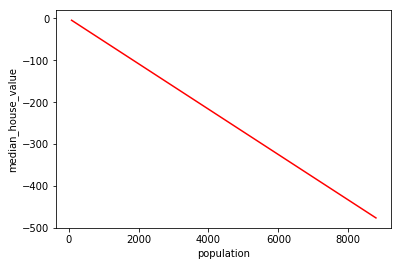

In [37]:
''' Plot data '''
# Get the min and max total_rooms values.
x_0 = sample["population"].min()
x_1 = sample["population"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/population/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

plt.ylabel("median_house_value")
plt.xlabel("population")

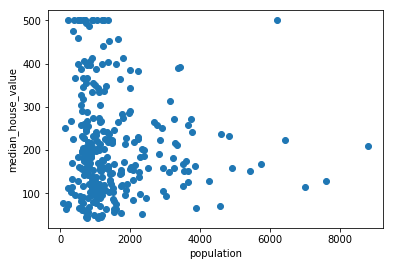

In [38]:
''' Create a scatter plot '''
# Plot a scatter plot from our data sample.
plt.scatter(sample["population"], sample["median_house_value"])

plt.xlabel("population")
plt.ylabel("median_house_value")

# Display graph.
plt.show()